# Building Bioinformatics Workflows with SnakeMake

## BST 281 Guest Lecture
### April 28, 2025

# Why Learn Workflow Languages?

<ul>
    <li>They allow you to build <b>modular</b>, <b>reproducible</b>, and <b>scalable</b> workflows</li>
    <li>Different processes can be parallelized and resource allocation optimized.</li>
    <li>Popular among bioinformaticians across industries, making it a great transferable skill.</li>
</ul>

<a href="https://snakemake.readthedocs.io/en/stable/" target="_blank"><b>Snakemake</b></a> has Python-based syntax and integrates well with conda environments, making it relatively easy to learn. 

Another popular workflow language is <a href="https://www.nextflow.io/" target="_blank"><b>Nextflow</b></a>.

# Worfklow Components:

There are 2 major components of a snakemake workflow:

1. Rules
2. Snakefile

The rules define the steps of the workflow, and the snakefile defines the aggregate workflow. We'll get into the details below.

# Rules

Each step in a snakemake pipeline is called a <b>rule</b>.

In addition to the exact code to run, each rule defines the input and output files, additional parameters, conda environments (if applicable).

The following is template for a simple rule:

```snakemake
rule myrule:
    input:
        fName1 = "path/to/inputfile",
        fName2 = "path/to/other/inputfile",
    output:
        output1 = "path/to/outputfile",
        output2 = "path/to/another/outputfile",
    shell:
        """
        somecommand {input.fName1} {output.output1}
        somecommand {input.fName1} {output.output2}
        """
```

The commands in the `shell` block are executed as they would be on the command line. You can also run Python itself, with the `run` block:

```snakemake
rule myrule:
    input:
        fName1 = "path/to/inputfile",
        fName2 = "path/to/other/inputfile",
    output:
        output1 = "path/to/outputfile",
        output2 = "path/to/another/outputfile",
    run:
        # this is a python command
        print(f"Filename 1: {input.fName1}, Filename 2: {input.fName2}")
```

You can access all components of the `input`, `output`, and other blocks using the syntax `block_name.attribute`, without the `{}`. However, because I used an f-string above, I included the braces as required by the f-string format.

Importantly, if you define an output file in the `output` block, that file must be generated by the rule, otherwise snakemake will give you an error.

# Directed Acylic Graph (DAG) of Jobs

Once you have all of your rules defined, you define the workflow by the desired outputs. 

Snakemake than builds a graph of the rules to work backwards and determine all the rules that must be run in order to achieve the desired outputs.

This is a directed acyclic graph (DAG).

How do we define the output of the worfklow? In the snakefile!

# Snakefile

The rules that will be used in the workflow need to be imported, similar to the `#include` statement in C++ programs.

After that, you define the desired outputs, like so:

```
import pandas as pd

output_dir = config["output_dir"]

# Import rules
include: "rules.smk"

# read in a dataframe of samples to process
df_samples_runs = pd.read_csv(config['isolates_to_run'])

rule all:
    input:
        [f"{output_dir}/{sample}/output_file.txt" for sample in df_samples_runs['Sample'].values]

```

Here, I defined a list of samples to run the workflow on from a dataframe. Because Snakemake is python-based, you can import python packages like `pandas` and read them in as you normally would in python.

Also note that I referenced a config file. The `config` variable is a global variable that is accessible in both the snakefile and the rules file.

# Conda Integration

Since many packages have different dependencies, it is useful to be able to have different virtual environments for different steps. Snakemake allows defining different conda environments like so:

```snakemake
rule myrule:
    input:
        fName1 = "path/to/inputfile",
        fName2 = "path/to/other/inputfile",
    output:
        output1 = "path/to/outputfile",
        output2 = "path/to/another/outputfile",
    shell:
        """
        somecommand {input.fName1} {output.output1}
        somecommand {input.fName1} {output.output2}
    conda:
        "envs/myenv.yaml"
```

# Putting it all together

To run a workflow from the command line, the basic syntax is

```bash
snakemake --snakefile snakefile --use-conda --conda-frontend conda --configfile config.yaml --cores 1

```

You MUST specify the number of cores, otherwise snakemake will throw an error. 

In the above code, I specified the snakefile and config file to use. You can also change things like the home directory for a workflow (so all relative paths will be relative to this directory) with the `--directory` flag and specify a different directory where conda environments are stored than in this home directory with the `--conda-prefix` flag.

You can also set the maximum available RAM with something like `--resources mem_mb=8000`, meaning that there are 8 GB of RAM available. 

To get the DAG for a particular process, you can run the following to save an image of the DAG.

```bash
snakemake --snakefile snakefile --use-conda --conda-frontend conda --configfile config.yaml --cores 1 --dag | dot -Tsvg > dag.svg
```

We won't use these, but there are some additional helpful flags:

<ul>
    <li><code>--unlock</code>: Snakemake locks a directory in which a workflow is running, so you can not run multiple workflows from the same directory to prevent potential conflicts in the output files. The directory is unlocked once the process completes. Use this flag to unlock a directory, for example, if a process was interrupted.</li>
    <li><code>--rerun-incomplete</code>: If a snakemake process is interrupted and some steps (jobs) only partially finished, rerun those</li>
    <li><code>--keep-going</code>: If one job fails, but there are other jobs that do not rely on its outputs, run them. This is useful if you have many samples, and one fails, but the workflow can continue processing the others.</li>
    <li><code>--dry-run</code>: Perform a dry run of the worfklow to ensure that the graph of jobs is valid and that all required inputs are present.</li>
</ul>

# Activity: Short-Read Processing and Classification for <i>M. tuberculosis</i>

In this short activity, we will download short-read whole-genome sequencing for <i>Mycobacterium tuberculosis</i>, perform quality-control, and perform taxonomic classification.

To get a pure bacterial sample, typically a sputum sample (coughed up by patients with respiratory infections) is cultured to select for the pathogen of interest. However, this loses some microbial diversity because the population is heterogeneous. There may be different <i>M. tuberculosis</i> clones in a single patient.

Therefore, the sample we will be working with has been sequenced directly from sputum, without the culturing step, which leads to more DNA contaminants from

<ul>
    <li>Host (human)</li>
    <li>Lung commensal bacteria</li>
    <li>Environmental bacteria that commonly contaminate any laboratories</li>
</ul>

## Processing Steps

1. Download FASTQ files using `sratoolkit`
2. Get quality control statistics on read length and quality using `fastqc` and `seqkit`.
3. Trim sequencing adapters and remove reads that are too short using `fastp`.
4. Perform taxonomic classification (actually we won't do this because it is too memory-intensive, so I have provided the output file) using `kraken2`.

After this, we will inspect the taxonomic classifications of reads to see if they make sense with what we expect.

# 1. Notebook Set Up

In [8]:
import os, glob, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

out_dir = os.getcwd()

## 2. Read Quality Control

In [267]:
df_seq_stats = pd.concat([pd.read_csv(fName, sep='\t') for fName in glob.glob(f"{out_dir}/results/*/*/read_QC/*.tsv")])
len(df_seq_stats)

10

In [268]:
df_seq_stats['Run'] = df_seq_stats['file'].apply(lambda x: os.path.basename(x)).str.split('.').str[0]
df_seq_stats['Read'] = df_seq_stats['file'].apply(lambda x: os.path.basename(x)).str.split('.').str[1].str.split('.').str[0]

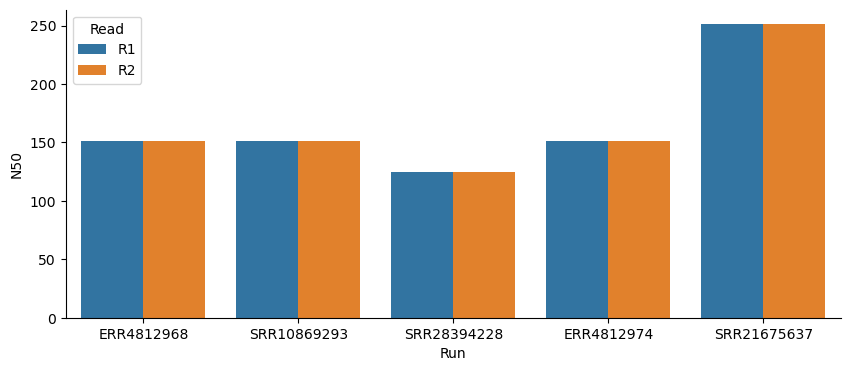

In [285]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.barplot(data=df_seq_stats,
            x='Run',
            y='N50',
            hue='Read',
            hue_order=['R1', 'R2'],
           )

sns.despine()
plt.show()

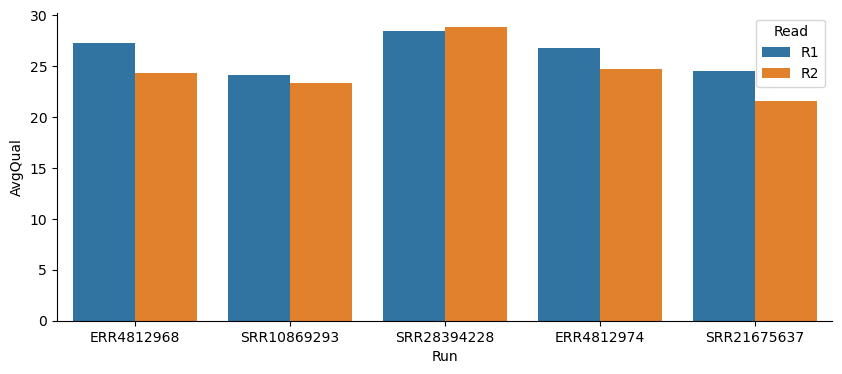

In [286]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.barplot(data=df_seq_stats,
            x='Run',
            y='AvgQual',
            hue='Read',
            hue_order=['R1', 'R2'],
           )

sns.despine()
plt.show()

## 3. Taxonomic Classification

For taxonomic classification, we will use the Kraken suite of tools for metagenomic classification from Johns Hopkins. 

Kraken tools use exact-matching of read k-mers against a Kraken database of k-mers from existing genomes.

For full read classification, kraken tools are preferred over other methods (like MetaPhlan) because they contain genome-wide k-mers, rather than only k-mers that distinguish between taxa. So they can be used for both sample-level classification and read-level classification.

https://www.nature.com/articles/s41596-022-00738-y
https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1891-0

In [5]:
kraken_fNames = glob.glob(f"{out_dir}/results/*/*/kraken/kraken_report.txt")
len(kraken_fNames)

5

In [19]:
df_kraken_summary = pd.DataFrame(columns=['SampleID', 'Unclassified_Perc', 'Mycobacteria_Perc', 'Second_Highest_Class', 'Second_Highest_Class_Perc', 'Human_Perc'])
i = 0

for i, fName in enumerate(kraken_fNames):

    sample = re.search(r"\bSAM\w+\d+\b", fName)[0]
    
    df_kraken_report = pd.read_csv(fName, sep='\t', header=None)
    df_kraken_report.columns = ['Percent_Reads', 'Num_Reads_Children', 'Num_Reads', 'Tax_Level', 'Tax_ID', 'Tax_Name']
    df_kraken_report = df_kraken_report.query("Num_Reads > 0").reset_index(drop=True)

    unclassified_reads_percent = df_kraken_report.query("Tax_Level=='U'").Percent_Reads.values[0]
    
    mycobacteria_reads_percent = df_kraken_report.query("Tax_ID==1763").Percent_Reads.values[0]

    second_highest_class = df_kraken_report.query("Tax_Level=='C' & ~Tax_Name.str.contains('Actinobacteria')").sort_values("Percent_Reads", ascending=False).Tax_Name.values[0]
    second_highest_class_reads_percent = df_kraken_report.query("Tax_Name==@second_highest_class").Percent_Reads.values[0]

    human_reads_percent = df_kraken_report.query("Tax_Name.str.contains('Homo sapiens')").Percent_Reads.values[0]
    
    df_kraken_summary.loc[i, :] = [sample, unclassified_reads_percent, mycobacteria_reads_percent, second_highest_class.lstrip().rstrip(), second_highest_class_reads_percent, human_reads_percent]
    i += 1

In [20]:
df_kraken_summary

,SampleID,Unclassified_Perc,Mycobacteria_Perc,Second_Highest_Class,Second_Highest_Class_Perc,Human_Perc
0,SAMEA7546473,6.29,48.48,Gammaproteobacteria,44.82,0.05
1,SAMN13813841,18.17,44.31,Bacilli,32.16,1.28
2,SAMN05916286,8.25,50.95,Bacilli,40.31,0.01
3,SAMEA7546479,7.28,52.43,Bacilli,40.19,0.03
4,SAMN30962275,5.56,50.11,Bacilli,44.15,0.01


In [278]:
def get_child_taxids(parent_taxid, email, max_results=500):
    '''
    1000 is the largest number of requests that can be returned at once. 
    
    Here, we're going to chunk it up into groups of 500 so that we don't submit too many requests at once.
    '''
    
    Entrez.email = email

    # Initialize variables
    all_taxids = []
    ret_start = 0

    while True:
        
        # Search for child taxids and keep going until all have been saved to a list
        search_handle = Entrez.esearch(db="taxonomy", term=f"txid{parent_taxid}[Subtree]", retstart=ret_start, retmax=max_results)
        search_results = Entrez.read(search_handle)
        search_handle.close()

        # Extract the list of taxids from the current batch
        id_list = search_results["IdList"]
        
        if not id_list:
            break  # No more results to fetch

        # Fetch details for the found taxids
        fetch_handle = Entrez.efetch(db="taxonomy", id=",".join(id_list), retmode="xml")
        fetch_results = Entrez.read(fetch_handle)
        fetch_handle.close()

        # Extract the taxids and add to cumulative list
        child_taxids = [taxon["TaxId"] for taxon in fetch_results]
        all_taxids.extend(np.unique(child_taxids))

        # if the number of returned taxids is the same as the maximum that can be returned, it means there are more than can be retrieved
        # so increment ret_start and keep going
        if len(child_taxids) == max_results:

            # break
            ret_start += max_results

            # wait to prevent a too many requests error
            time.sleep(1)

        # break out of the loop if we've retrieved all results
        else:
            break

    return np.array(all_taxids).astype(int)

## Questions

### a. What percent of reads map to <i>Mycobacterium tuberculosis</i>?

### b. What percent of reads map to <i>Homo sapiens</i>?

### c. What is the most common bacterial genus in this sample?

### d. What is the second most common bacterial genus in this sample?

In [16]:
df_kraken_report.query("Tax_Name.str.contains('Homo')")

,Percent_Reads,Num_Reads_Children,Num_Reads,Tax_Level,Tax_ID,Tax_Name
385,0.01,71,71,S,9606,...


In [14]:
df_kraken_report.query("Tax_Name.str.contains('Mycobacterium') & Tax_Level in ['G', 'G1']")

,Percent_Reads,Num_Reads_Children,Num_Reads,Tax_Level,Tax_ID,Tax_Name
9,23.92,370923,298290,G,1763,Mycobacterium
10,4.27,66206,32618,G1,77643,Mycobacterium tuberculosis c...
150,0.11,1665,121,G1,2249310,Mycobacterium simiae complex
158,0.06,867,204,G1,120793,Mycobacterium avium complex ...
180,0.03,491,52,G1,2642494,unclassified Mycobacterium
